# DistilBert

### Import necessary packages

In [ ]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [ ]:
DATA_PATH = "../data/data_dropped_duplicates_small.csv"
# DATA_PATH = "../data/data_tiny.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_finetuned_1/trainer_output"
SAVE_PATH = "../models/distilbert_finetuned_1/pytorch_model"

### Get data

In [5]:
train_dataset, test_dataset, y_train, le = get_encode_tokenize_data(DATA_PATH, MODEL_PATH)

INFO:basic_functions:Loading data...
INFO:basic_functions:Train test split, test-size 0.3
INFO:root:encode the label column
INFO:root:tokenize
INFO:basic_functions:create tokenizer & load model
INFO:basic_functions:create tokenizer & load model
INFO:root:create TextDatasets (train & test)


### Model Initialization

In [6]:
num_classes = len(np.unique(y_train))
num_classes

6

In [7]:
# Load config and set dropout
config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes # Set number of labels for classification
config.dropout = 0.3 # Set dropout, default is 0.1

# Load model with updated config
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    config=config  # Pass modified config
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
params = {
      "learning_rate": 3e-5,
      "weight_decay": 0.01,
      "num_train_epochs": 4,
      "evaluation_strategy": "epoch",
      "class_weight":True,
      "dropout": 0.3,
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "distilbert finetuned")
mlflow.log_params(params)

Active run_id: 34b5504593794bd580fa28d57afe3b18


In [13]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=True, 
    epochs=1, 
    learning_rate=3e-5, 
    weight_decay = 0.01, 
    train_batch_size=4, 
    eval_batch_size=8 )

INFO:root:defining training arguments
INFO:root:get weighted loss trainer


### Execute Training

In [14]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [15]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [16]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.780384,0.433333


TrainOutput(global_step=18, training_loss=1.762279404534234, metrics={'train_runtime': 113.4194, 'train_samples_per_second': 0.617, 'train_steps_per_second': 0.159, 'total_flos': 9273379368960.0, 'train_loss': 1.762279404534234, 'epoch': 1.0})

### Evaluation


In [17]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score 

                       precision    recall  f1-score   support

           ad_hominem       0.00      0.00      0.00         2
  appeal_to_authority       0.00      0.00      0.00         2
    appeal_to_emotion       0.00      0.00      0.00         6
        false_dilemma       0.00      0.00      0.00         3
faulty_generalization       0.00      0.00      0.00         4
                 none       0.43      1.00      0.60        13

             accuracy                           0.43        30
            macro avg       0.07      0.17      0.10        30
         weighted avg       0.19      0.43      0.26        30

[[ 0  0  0  0  0  2]
 [ 0  0  0  0  0  2]
 [ 0  0  0  0  0  6]
 [ 0  0  0  0  0  3]
 [ 0  0  0  0  0  4]
 [ 0  0  0  0  0 13]]


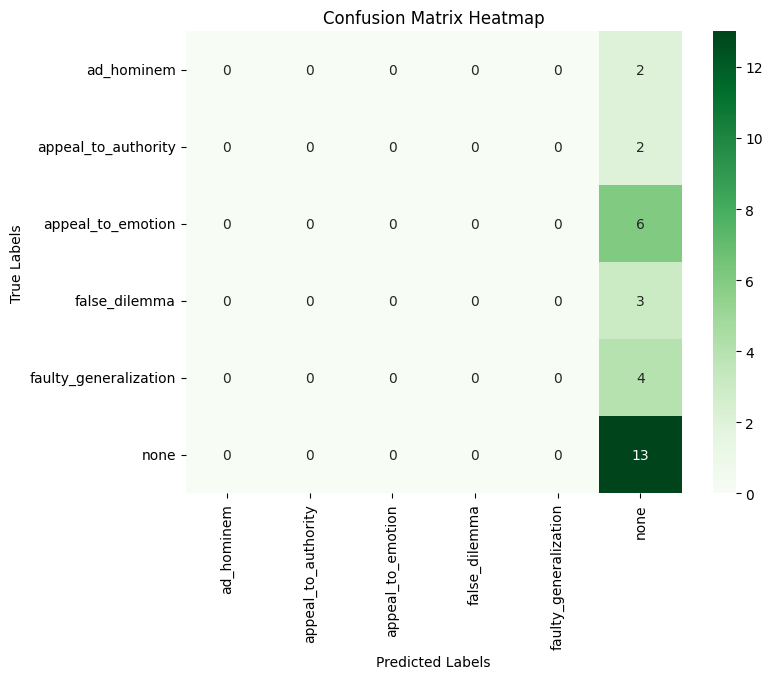

INFO:basic_functions:brier score


Multiclass Brier score: 0.7654608733133477


In [18]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score 

                       precision    recall  f1-score   support

           ad_hominem       0.00      0.00      0.00         5
  appeal_to_authority       0.00      0.00      0.00         4
    appeal_to_emotion       0.00      0.00      0.00        14
        false_dilemma       0.00      0.00      0.00         7
faulty_generalization       1.00      0.10      0.18        10
                 none       0.43      1.00      0.61        30

             accuracy                           0.44        70
            macro avg       0.24      0.18      0.13        70
         weighted avg       0.33      0.44      0.29        70

[[ 0  0  0  0  0  5]
 [ 0  0  0  0  0  4]
 [ 0  0  0  0  0 14]
 [ 0  0  0  0  0  7]
 [ 0  0  0  0  1  9]
 [ 0  0  0  0  0 30]]


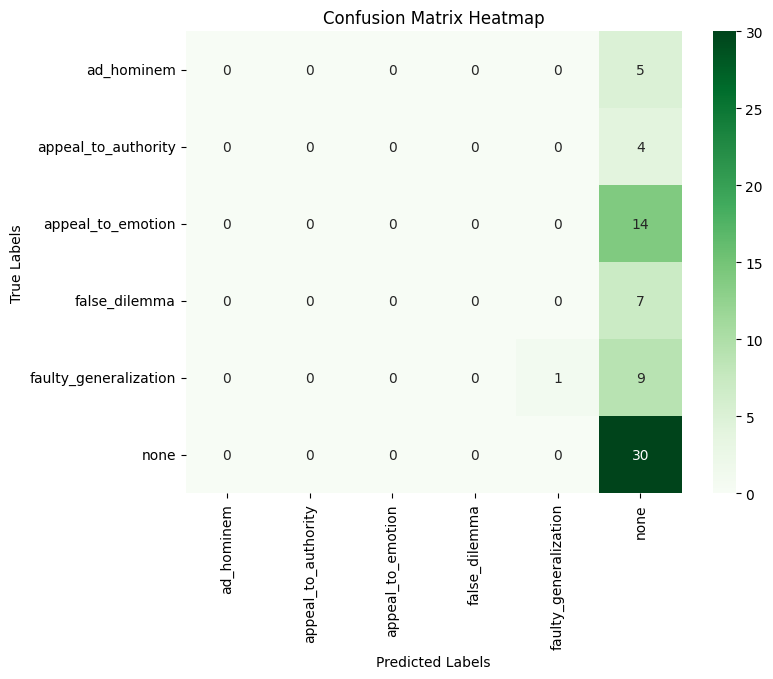

INFO:basic_functions:brier score


Multiclass Brier score: 0.7405510116587487


In [19]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [20]:
mlflow.end_run()

🏃 View run test parameter logging at: http://127.0.0.1:5001/#/experiments/445989666823303942/runs/34b5504593794bd580fa28d57afe3b18
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/445989666823303942


### Save model

In [ ]:
#save with pytorch
mlflow.pytorch.save_model(model, path=SAVE_PATH)